In [1]:
import numpy as np      
import matplotlib.pyplot as plt 
import scipy.io.wavfile 
import subprocess
import librosa
import librosa.display
import IPython.display as ipd

from pathlib import Path, PurePath   
from tqdm.notebook import tqdm

## Utility functions

In [2]:
def convert_mp3_to_wav(audio:str) -> str:  
    """Convert an input MP3 audio track into a WAV file.

    Args:
        audio (str): An input audio track.

    Returns:
        [str]: WAV filename.
    """
    if audio[-3:] == "mp3":
        wav_audio = audio[:-3] + "wav"
        if not Path(wav_audio).exists():
                subprocess.check_output(f"ffmpeg -i {audio} {wav_audio}", shell=True)
        return wav_audio
    
    return audio

def plot_spectrogram_and_peaks(track:np.ndarray, sr:int, peaks:np.ndarray, onset_env:np.ndarray) -> None:
    """Plots the spectrogram and peaks 

    Args:
        track (np.ndarray): A track.
        sr (int): Aampling rate.
        peaks (np.ndarray): Indices of peaks in the track.
        onset_env (np.ndarray): Vector containing the onset strength envelope.
    """
    times = librosa.frames_to_time(np.arange(len(onset_env)),
                            sr=sr, hop_length=HOP_SIZE)

    plt.figure()
    ax = plt.subplot(2, 1, 2)
    D = librosa.stft(track)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=np.max),
                            y_axis='log', x_axis='time')
    plt.subplot(2, 1, 1, sharex=ax)
    plt.plot(times, onset_env, alpha=0.8, label='Onset strength')
    plt.vlines(times[peaks], 0,
            onset_env.max(), color='r', alpha=0.8,
            label='Selected peaks')
    plt.legend(frameon=True, framealpha=0.8)
    plt.axis('tight')
    plt.tight_layout()
    plt.show()

def load_audio_peaks(audio, offset, duration, hop_size):
    """Load the tracks and peaks of an audio.

    Args:
        audio (string, int, pathlib.Path or file-like object): [description]
        offset (float): start reading after this time (in seconds)
        duration (float): only load up to this much audio (in seconds)
        hop_size (int): the hop_length

    Returns:
        tuple: Returns the audio time series (track) and sampling rate (sr), a vector containing the onset strength envelope
        (onset_env), and the indices of peaks in track (peaks).
    """
    try:
        track, sr = librosa.load(audio, offset=offset, duration=duration)
        onset_env = librosa.onset.onset_strength(track, sr=sr, hop_length=hop_size)
        peaks = librosa.util.peak_pick(onset_env, 10, 10, 10, 10, 0.5, 0.5)
    except Error as e:
        print('An error occurred processing ', str(audio))
        print(e)

    return track, sr, onset_env, peaks
    
    

## Settings

In [3]:
N_TRACKS = 1413
HOP_SIZE = 512
OFFSET = 1.0
DURATION = 30 # TODO: to be tuned!
THRESHOLD = 0 # TODO: to be tuned!

In [4]:
data_folder = Path("data/mp3s-32k/")
mp3_tracks = data_folder.glob("*/*/*.mp3")
tracks = data_folder.glob("*/*/*.wav")

## Preprocessing

In [5]:
for track in tqdm(mp3_tracks, total=N_TRACKS):
    convert_mp3_to_wav(str(track))

  0%|          | 0/1413 [00:00<?, ?it/s]

ffmpeg version 4.4 Copyright (c) 2000-2021 the FFmpeg developers
  built with clang version 11.1.0
  configuration: --prefix=/Users/runner/miniforge3/conda-bld/ffmpeg_1634180034885/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl --cc=arm64-apple-darwin20.0.0-clang --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/Users/runner/miniforge3/conda-bld/ffmpeg_1634180034885/_build_env/bin/pkg-config --enable-cross-compile --arch=arm64 --target-os=darwin --cross-prefix=arm64-apple-darwin20.0.0- --host-cc=/Users/runner/miniforge3/conda-bld/ffmpeg_1634180034885/_build_env/bin/x86_64-apple-darwin13.4.0-clan

## Audio signals

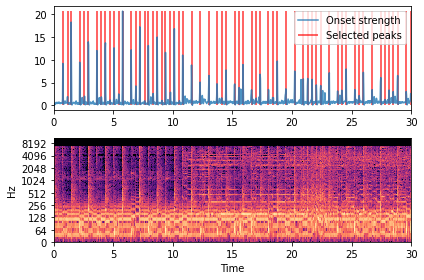

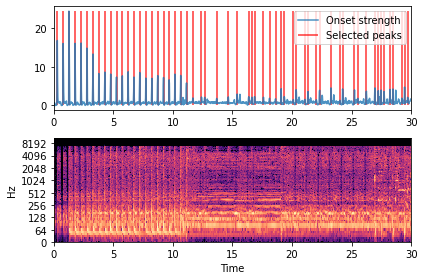

In [5]:
for idx, audio in enumerate(tracks):
    if idx >= 2:
        break
    track, sr, onset_env, peaks = load_audio_peaks(audio, OFFSET, DURATION, HOP_SIZE)
    plot_spectrogram_and_peaks(track, sr, peaks, onset_env)
        
        

## Minhash

In [7]:
import random
import numpy as np
import pandas as pd

In [32]:
def gen_coefficient(num, upper_bound):
    coeff = []
    for i in range(0, num):
        rand_value = random.randint(0, upper_bound) 
        #remove duplicates
        while rand_value in coeff:
            rand_value = random.randint(0, upper_bound) 
        coeff.append(rand_value)

    return coeff

h(x)=min(a◦x+b modw)

In [9]:
#hashing function
def hash(a, b, x, w):
    return (a * x + b) % w

In [37]:
UPPERBOUND = 2**32-1
TOTAL = 10
#first prime after upperbound
PRIME = 4294967311

coeff_A = gen_coefficient(TOTAL, UPPERBOUND)
coeff_B = gen_coefficient(TOTAL, UPPERBOUND)
# coeff_A, coeff_B

In [12]:
def gen_audio_signature(audio):
    signature = []
    track, sr, onset_env, peaks = load_audio_peaks(audio, OFFSET, DURATION, HOP_SIZE)

    for i in range(0, TOTAL) :
        hash_list = []
        for x in peaks:
            hash_value = hash(x, coeff_A[i], coeff_B[i], PRIME)
            hash_list.append(hash_value)

        #print(hash_list)        
        signature.append(min(hash_list))

    return signature

### TRACK MINHASH

In [38]:
tracks_signature = []
data_folder = Path("data/mp3s-32k/")
tracks = data_folder.glob("*/*/*.wav")


for idx, audio in tqdm(enumerate(tracks), total=N_TRACKS):

    #if idx > 520 and idx < 530:
    print(str(audio))
    audio_signature = gen_audio_signature(audio)
    tracks_signature.append((idx, audio, audio_signature))

  0%|          | 0/1413 [00:00<?, ?it/s]

data/mp3s-32k/metallica/Metallica/10-The_God_that_Failed.wav
data/mp3s-32k/metallica/Metallica/09-Of_Wolf_and_Man.wav
data/mp3s-32k/metallica/Metallica/06-Dont_Tread_on_Me.wav
data/mp3s-32k/metallica/Metallica/08-Nothing_Else_Matters.wav
data/mp3s-32k/metallica/Metallica/11-My_Friend_of_Misery.wav
data/mp3s-32k/metallica/Metallica/02-Sad_but_True.wav
data/mp3s-32k/metallica/Metallica/04-The_Unforgiven.wav
data/mp3s-32k/metallica/Metallica/05-Wherever_I_May_Roam.wav
data/mp3s-32k/metallica/Metallica/07-Through_the_Never.wav
data/mp3s-32k/metallica/Metallica/01-Enter_Sandman.wav
data/mp3s-32k/metallica/Metallica/12-The_Struggle_Within.wav
data/mp3s-32k/metallica/Metallica/03-Holier_than_Thou.wav
data/mp3s-32k/metallica/Ride_The_Lightning/04-Fade_To_Black.wav
data/mp3s-32k/metallica/Ride_The_Lightning/06-Escape.wav
data/mp3s-32k/metallica/Ride_The_Lightning/03-For_Whom_The_Bell_Tolls.wav
data/mp3s-32k/metallica/Ride_The_Lightning/08-The_Call_Of_Ktulu.wav
data/mp3s-32k/metallica/Ride_The_L

In [39]:
#save track signature to csv file
tracks_signature_df = pd.DataFrame(tracks_signature, columns=['idx', 'path', 'signature'])
tracks_signature_df.to_csv('tracks_signature.csv')

In [40]:
#load track signature
tracks_signature_ = pd.read_csv('tracks_signature.csv')

### QUERY MINHASH

In [41]:
query_tracks_ = Path("query/").glob("*.wav")

query_signature = []


for idx, audio in enumerate(query_tracks_):
    if idx >= 2:
        pass

    audio_signature = gen_audio_signature(audio)
    query_signature.append((idx, audio, audio_signature))
print(query_signature)

[(0, PosixPath('query/track8.wav'), [24205746, 16905223, 16436611, 63810848, 55237716, 47524334, 80990905, 36902250, 493599741, 8933427]), (1, PosixPath('query/track9.wav'), [208539821, 96544634, 61751138, 93267014, 130736126, 91293932, 91225806, 734198, 773200764, 8933427]), (2, PosixPath('query/track10.wav'), [55882734, 33479255, 3635804, 16910226, 51188254, 15209588, 51782246, 230401885, 493599741, 8933427]), (3, PosixPath('query/track2.wav'), [47963487, 3621981, 15595368, 77467299, 43329558, 31366961, 80616894, 42689194, 493599741, 16743130]), (4, PosixPath('query/track3.wav'), [42235634, 58400344, 84829023, 204014191, 45354289, 139766051, 71130015, 42689194, 495309839, 138626]), (5, PosixPath('query/track1.wav'), [89751116, 152968392, 3635804, 3253775, 156577173, 58979186, 4347851, 3989267, 492744692, 92941045]), (6, PosixPath('query/track4.wav'), [448005, 151322997, 60068652, 6543257, 55237716, 47524334, 13460719, 45944263, 498730035, 17071496]), (7, PosixPath('query/track5.wav')

In [42]:
#save query signature to csv file
query_signature_df = pd.DataFrame(query_signature, columns=['idx', 'path', 'signature'])
query_signature_df.to_csv('query_signature.csv')

In [43]:
#load track signature
query_signature_ = pd.read_csv('query_signature.csv')

### MATCHING

In [23]:
# Jaccard Similarity function
def jaccard(A, B):
    return len(A.intersection(B))/len(A.union(B))

In [67]:
hash_sign = []

def audio_match(threshold):
    for i, row_q in query_signature_.iterrows():
        for j, row_t in tracks_signature_.iterrows():

            track_hash_sign = list(map(int, row_t['signature'].strip('][').split(', ')))
            query_hash_sign = list(map(int, row_q['signature'].strip('][').split(', ')))

            idx = int(row_t.idx)
            track_path = row_t.path
            track_artist = track_path.split('/')[2].replace('_', ' ')
            track_album = track_path.split('/')[3].replace('_', ' ')
            track_title = track_path.split('/')[-1].split('-')[-1].replace('.wav', '').replace('_', ' ')

            query_path = row_q.path
            query_title = query_path.split('/')[-1]


            jaccard_sim = jaccard(set(query_hash_sign), set(track_hash_sign) )

            if jaccard_sim >= threshold:
                print("Query:", str(query_title))
                print("Matched with:", track_path)
                print("Title:", track_title)
                print("Album:", track_album)
                print("Artist:", track_artist)
                print("Similarity score:", jaccard_sim)
                print()

In [68]:
audio_match(1.0)

Query: track8.wav
Matched with: data/mp3s-32k/green_day/American_Idiot/01-American_Idiot.wav
Title: American Idiot
Album: American Idiot
Artist: green day
Similarity score: 1.0

Query: track9.wav
Matched with: data/mp3s-32k/depeche_mode/Some_Great_Reward/06-Somebody.wav
Title: Somebody
Album: Some Great Reward
Artist: depeche mode
Similarity score: 1.0

Query: track10.wav
Matched with: data/mp3s-32k/steely_dan/Katy_Lied/01-Black_Friday.wav
Title: Black Friday
Album: Katy Lied
Artist: steely dan
Similarity score: 1.0

Query: track2.wav
Matched with: data/mp3s-32k/queen/The_Works/06-I_Want_To_Break_Free.wav
Title: I Want To Break Free
Album: The Works
Artist: queen
Similarity score: 1.0

Query: track3.wav
Matched with: data/mp3s-32k/u2/October/07-October.wav
Title: October
Album: October
Artist: u2
Similarity score: 1.0

Query: track1.wav
Matched with: data/mp3s-32k/aerosmith/Aerosmith/03-Dream_On.wav
Title: Dream On
Album: Aerosmith
Artist: aerosmith
Similarity score: 1.0

Query: track4

In [69]:
audio_match(0.2)

Query: track8.wav
Matched with: data/mp3s-32k/steely_dan/Countdown_To_Ecstasy/08-King_Of_The_World.wav
Title: King Of The World
Album: Countdown To Ecstasy
Artist: steely dan
Similarity score: 0.25

Query: track8.wav
Matched with: data/mp3s-32k/green_day/American_Idiot/01-American_Idiot.wav
Title: American Idiot
Album: American Idiot
Artist: green day
Similarity score: 1.0

Query: track9.wav
Matched with: data/mp3s-32k/depeche_mode/Some_Great_Reward/06-Somebody.wav
Title: Somebody
Album: Some Great Reward
Artist: depeche mode
Similarity score: 1.0

Query: track10.wav
Matched with: data/mp3s-32k/steely_dan/Katy_Lied/01-Black_Friday.wav
Title: Black Friday
Album: Katy Lied
Artist: steely dan
Similarity score: 1.0

Query: track2.wav
Matched with: data/mp3s-32k/tori_amos/The_Beekeeper/15-Martha_s_Foolish_Ginger.wav
Title: Martha s Foolish Ginger
Album: The Beekeeper
Artist: tori amos
Similarity score: 0.25

Query: track2.wav
Matched with: data/mp3s-32k/queen/The_Works/06-I_Want_To_Break_Fr

In [70]:
audio_match(0.1)

Query: track8.wav
Matched with: data/mp3s-32k/metallica/Ride_The_Lightning/04-Fade_To_Black.wav
Title: Fade To Black
Album: Ride The Lightning
Artist: metallica
Similarity score: 0.1111111111111111

Query: track8.wav
Matched with: data/mp3s-32k/metallica/Load/01-Ain_t_My_Bitch.wav
Title: Ain t My Bitch
Album: Load
Artist: metallica
Similarity score: 0.1111111111111111

Query: track8.wav
Matched with: data/mp3s-32k/led_zeppelin/Led_Zeppelin_III/10-Hats_Off_To_Roy_Harper.wav
Title: Hats Off To Roy Harper
Album: Led Zeppelin III
Artist: led zeppelin
Similarity score: 0.1111111111111111

Query: track8.wav
Matched with: data/mp3s-32k/roxette/Joyride/03-fading_like_a_flower_everytime_you_leave_.wav
Title: fading like a flower everytime you leave 
Album: Joyride
Artist: roxette
Similarity score: 0.1111111111111111

Query: track8.wav
Matched with: data/mp3s-32k/roxette/Look_Sharp_/03-Sleeping_Single.wav
Title: Sleeping Single
Album: Look Sharp 
Artist: roxette
Similarity score: 0.1111111111111